### Utilizzando la rete creata dal 2 notebook di test, si testerà il caricamento della rete dal suo file di salvataggio ed il funzionamento della rete su foto reali. Bisognerà dunque eseguirne la segmentazione e colorarle in base alla classe riscontrata. <br><br>Nota Bene: La predizione finale può non essere ottimale perchè il training è stato fatto su un subset (ancora da addestrare con GPU)

# 1. Definizione Imports

In [1]:
#roba generica
import numpy as np
from pathlib import Path

#gestione dataframe
import pandas as pd

#per grafici
import cv2 as cv
import matplotlib.pyplot as plt

#pytorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

#modifica immagini (colorazione, blur, ecc ecc)
import albumentations as A
from albumentations.pytorch.transforms import ToTensor

#barre che mostrano il progresso
from fastprogress.fastprogress import master_bar, progress_bar

#Modello personalizzato della nostra rete neurale
from ConcreteModel import ConcreteModel
from ConcreteModel import getModelInputSize as InputSize
import os
import JDUtils
import random

In [2]:
seed = 123
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
np.random.seed(seed)  # Numpy module.
random.seed(seed)  # Python random module.
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

# 2. Definizione Variabili

## Definizione Variabili Generiche

In [3]:
#----- VARIABILE PER IL PERCORSO DEL DATASET -----
#path per le immagini da classificare
DS_PATH = Path('C:/Users/gianl/Downloads/ConcreteDataset/ToClassify')
#------------------------------------------------
#path per il percorso in cui andrò a caricare i parametri del modello
#le estensioni standard sono .pt e .pth
MODEL_SAVE_PATH= Path('./Test_Model_Params.pt')
#------------------------------------------------

#----- VARIABILE PER I PLOT -----
#Numero massimo di immagini da mostrare
plots = 4
#dimensioni delle immagini
#altezza
plots_height = 20
#larghezza
plots_width = 20

#----- VARIABILI PER IL DATAFRAME -----
#variabili che indicano il nome delle due colonne del dataset
c_filepath = "filepath"
#--------------------------------------

# Dimensione dell'input accettato dalla rete
size = InputSize()

#PRINT VALORE VARIABILI
print("----- Paths -----")
print("Path Dataset To Classify: " + str(DS_PATH))
print("Path Model Params: " + str(MODEL_SAVE_PATH))

----- Paths -----
Path Dataset To Classify: C:\Users\gianl\Downloads\ConcreteDataset\ToClassify
Path Model Params: Test_Model_Params.pt


## Definizione Variabili della Rete

In [4]:
#########################################################################################
##  PER QUESTE VARIABILI, UTILIZZARE LO STESSO VALORE SCELTO X IL TRAINING DELLA RETE  ##
#########################################################################################

# Nome della rete EfficientNet da utilizzare
network_model_name = "efficientnet-b0"

#NUMERO DI CLASSI DA CLASSIFICARE (NORMALE, CREPA, FERRO CHE ESCE)
output_number_of_classes = 3
OC = output_number_of_classes

# 3. Loading della rete

In [5]:
# Costruisco il modello di base della rete
model = ConcreteModel(eff_name = network_model_name, n_outs = OC)
# Carico il valore dei parametri
model.load_state_dict(torch.load(MODEL_SAVE_PATH))
# Prendo il device in uso
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
# Imposto il modello in eval (e non in training)
model.eval()
print("Model Loaded")

Loaded pretrained weights for efficientnet-b0
----- ConcreteModel ----
New Classifier Stats: 
Input features 1° Linear:  1280
Input features 2° Linear:  640
Input features 3° Linear:  320
Output 3° Linear:  3
------------------------
Model Loaded


# 4. Lettura immagine e predizione

## Dataset personalizzato, applica delle trasformazioni alle immagini prese in input

In [6]:
class ConcreteDataset(Dataset):
    def __init__(self, ds, transforms=None):
        self.ds = ds
        self.transforms = transforms
    
    def __len__(self):
        return len(self.ds)
    
    def __getitem__(self, idx):
        img = self.ds[idx]
        #print(idx)
        if type(img) == str:
            img = cv.imread(str(img))
        if self.transforms:
            #when using albumation we have to pass data as dictionary to transforms.
            #The output after transformation is also a dictionary
            #we need to take the value from dictionary. That is why we are giving an image at the end.
            img = self.transforms(**{"image": np.array(img)})["image"]
            return img, idx

## Preparazione Dati e Trasformazione

In [7]:
# Carico i dati
data_to_predict = [o for o in DS_PATH.iterdir()]
data_dimension = len(data_to_predict)

# Trasformazioni da applicare ai dati
imagenet_stats = {'mean':[0.485, 0.456, 0.406], 'std':[0.229, 0.224, 0.225]}
width, height, _ = size
#Trasformazioni x il set di validation e di test
tfms = A.Compose([
        A.Resize(width, height),
        ToTensor(normalize = imagenet_stats)
    ])

print("Dati da predirre: ", data_dimension)

Dati da predirre:  4


## Metodo x predirre e colorare l'immagine

In [8]:
import tempfile
import math
        
def predict_on_crops(model, input_image, height=227, width=227, save_crops=False, batch_size = 128):
    # Leggo l'immagine, la parte finale serve x la traduzione dei colori, altrimenti rimane tutta bluastra
    img = cv.imread(str(input_image))
    imgheight, imgwidth, imgchannels = img.shape
    # Contiene la colorazione delle sub-images in base alla loro classificazione del modello
    output_image = np.zeros_like(img)
    
    # Preparo le sub_images
    sub_imgs = []
    cont = 0
    #numero di immagini che avrò
    with tempfile.TemporaryDirectory() as temp_dir:
        # Eseguo i tagli all'immagine, per avere sub-images di dimensione corretta per la rete
        for i in range(0, imgheight, height):
            for j in range(0, imgwidth, width):
                subimg = img[i:i+height, j:j+width]
                #subimg_path = os.path.join(temp_dir, str(cont)+".jpg")
                #cv.imwrite(subimg_path, subimg)
                sub_imgs.append(subimg)
                cont+=1
        # Trasformo la lista delle sub-images applicandoci le trasformazioni (trasformo in tensori ecc ecc)
        n_subimgs = len(sub_imgs)
        sub_imgs_cds = ConcreteDataset(ds = sub_imgs, transforms = tfms)
        sub_imgs_dl = DataLoader(dataset = sub_imgs_cds, batch_size = batch_size, shuffle = True, num_workers = 0)
        
        # Predizione delle sub-images
        # Creo la progressbar
        data_table = master_bar(range(n_subimgs))
        # Risultati delle predizioni
        results = np.zeros(n_subimgs)
        # Classifico le sub-images in base al batch_size
        with torch.no_grad():
            device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
            for i, (xb, yb) in enumerate(progress_bar(sub_imgs_dl)):
                xb = xb.to(device)
                output = model(xb)
                bs = xb.shape[0]
                dresults = torch.max(output, 1).indices.cpu().numpy()
                for j, (y) in enumerate(yb):
                    #Trasformo il tensore risultato, prendendo il valore maggiore che mi indica la classe
                    results[y] = dresults[j]
                
        # Per ogni immagine, creo un nuovo layer contenente il colore della predizione
        # Eseguo il merge fra l'immagine iniziale e questo layer per mostrare la colorazione sull'immagine
        cont = 0
        for i in range(0, imgheight, height):
            for j in range(0, imgwidth, width):
                # Sub-image di riferimento
                subimg = sub_imgs[cont]
                # Classificazione fatta per la sub-image
                predicted_class = results[cont]
                merge_img = subimg
                # Se ho predetto qualcosa di diverso da 'normale'
                if predicted_class > 0:
                    # Crepa
                    if predicted_class == 1:
                        #BLU
                        color = (0, 0, 255)
                    # Spalling
                    else:
                        #VERDE
                        color = (0, 255, 0)
                    # creo un layer di dimensione della sub-image
                    classification_layer = np.zeros_like(subimg, dtype = np.uint8)
                    # coloro il layer del colore definito dalla classificazione
                    classification_layer[:] = color
                    # Definisco la merge_img come il merge fra la subimg e il nuovo layer dando priorità alla subimg
                    # (Il colore deve giusto essere una trasparenza colorata)
                    merge_img = cv.addWeighted(subimg, 0.9, classification_layer, 0.1, 0)
                # Imposto la sezione dell'immagine di output con la merge_img
                output_image[i:i+height, j:j+width] = merge_img
                # Passo alla prossima subimg
                cont += 1
    # Ritorno l'immagine di output contenente per ogni subimg la sua classificazione colorata se non è 'normale'
    return output_image

### Stampo a schermo le immagini con le predizioni

Legenda:
Quadrato Blu: Rottura
Quadrato Verde: Spalling


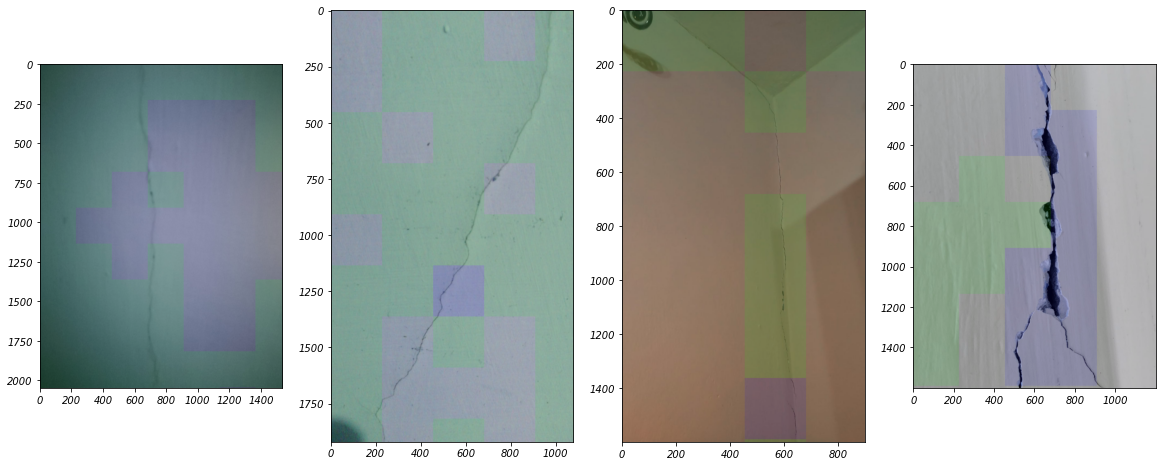

In [18]:
#creo plot ed imposto le dimensioni
# Per evitare di consumare troppo spazio a schermo
# Se ho più di 4 immagini ne mostro solo 4
n_plots = 0
if data_dimension < plots:
    n_plots = data_dimension
else:
    n_plots = plots
if n_plots > 4:
    n_plots = 4
    
fig,a =  plt.subplots(1, n_plots)
fig.set_figheight(plots_height)
fig.set_figwidth(plots_width)

print("Legenda:")
print("Quadrato Blu: Rottura")
print("Quadrato Verde: Spalling")
# Faccio partire per ogni immagine la predizione e la stampo a schermo
i = 0
for path in data_to_predict:
    output_image = predict_on_crops(model, path, width, height)
    if i < n_plots:
        if n_plots > 1:
            a[i].imshow(output_image)
        else:
            a.imshow(output_image)
        i = i + 1

In [16]:
#sub_imgs_df = pd.DataFrame(data_to_predict, columns=[c_filepath])
sub_imgs_cds = ConcreteDataset(ds = data_to_predict, transforms = tfms)
sub_imgs_dl = DataLoader(dataset = sub_imgs_cds, batch_size = 64, shuffle = True, num_workers = 0)

In [17]:
%%time
with torch.no_grad():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    for i, (xb, yb) in enumerate(sub_imgs_dl):
        xb = xb.to(device)
        output = model(xb)

out = torch.max(output, 1).indices.cpu().numpy()
fig,a =  plt.subplots(1, len(data_to_predict))
fig.set_figheight(plots_height)
fig.set_figwidth(plots_width)
i = 0
for i, (path) in enumerate(data_to_predict):
    classe = out[i]
    print(classe)
    a[i].imshow(cv.imread(str(path))[...,::-1])
    if classe == 0:
        a[i].set_title("Predizione: NORMALE")
    elif classe == 1:
        a[i].set_title("Predizione: CRACK")
    else:
        a[i].set_title("Predizione: SPALLING")
            

IndexError: tuple index out of range